In [ ]:
import torch, numpy as np
from transformers import CLIPProcessor, CLIPModel
import time

import os
start = time.time()

device = "cuda" if torch.cuda.is_available() else "mps"
model = CLIPModel.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k").to(device)
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k")# openai/clip-vit-large-patch14

print(time.time() - start)

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/120k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

In [3]:
z = [4.9139564037323, 5.16338586807251, 3.946835517883301, 
     5.232940196990967, 5.269499063491821, 5.722091197967529]
print(np.mean(z), np.std(z))

5.041451374689738 0.544862543634317


In [4]:
# concepts = [
#  "picture of roads made out of soil",
#  "picture of people",
#  "picture of roads made out of asphalt",
#  "picture of people wearing dark clothes",
#  "picture of people wearing colorful clothes"]
concepts = ["white person"]
# concepts = ["woman"]


anchors = ['germany', 'nigeria']
# #natural
# negconcepts = ["picture of roads made out of asphalt",
# "picture with no people in it",
# "picture of roads made out of soil",
# "picture of people wearing colorful clothes",
# "picture of people wearing dark clothes"]
negconcepts = ["latino person"]
# negconcepts = ["man"]

for i in range(len(concepts)):
    print(i, concepts[i], '->', negconcepts[i])

0 white person -> latino person


In [5]:
from utils import zero_shot
import numpy as np
import json
from glob import glob

images = glob(f"s1/*.png")
zero_labels = [json.loads(open(f"{images[i]}.json").read())['metadata']['labels'] for i in range(len(images))]
# man_woman = [int(images[i].split('-')[-3]) for i in range(len(images))] #1 -> woman
# age = [int(images[i].split('-')[-2]) for i in range(len(images))]
# race = ['white' in images[i].split('-')[-1].split('.')[0] for i in range(len(images))] #1 -> white

# age_ranges = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]

Model loaded


In [ ]:

times = []

for i in range(10):
    start = time.time()
    prediction = zero_shot(images, concepts[:1], negconcepts, batch_size=16,
                       model=model, processor=processor, device=device)
    times.append(time.time() - start)


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


In [13]:
print(np.mean(times), np.std(times))

0.19967777729034425 0.008092476954517085


In [30]:
images[0]

'fairface-annotated/latino-hispanic-0-1-68.jpg'

In [ ]:
# one_hot = np.zeros((len(images), len(concepts)))
# for j, i in enumerate(man_woman):
#     one_hot[j, i] = 1
prediction

In [28]:

from sklearn.metrics import f1_score
f1 = f1_score(np.array(race).reshape(100, 1), prediction.cpu().numpy(), average=None)
print("Metric per class:", f1)
print("Mean metric:", np.mean(f1))

Metric per class: [0.80952381 0.        ]
Mean metric: 0.40476190476190477


In [ ]:
man/woman -> 0.945
white / latino -> 0.404


# Proximity of person to woman, and man

In [ ]:
import torch, numpy as np
from transformers import CLIPProcessor, CLIPModel
import time

import os
start = time.time()

device = "cuda" if torch.cuda.is_available() else "mps"
model = CLIPModel.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k").to(device)
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-bigG-14-laion2B-39B-b160k")# openai/clip-vit-large-patch14


from utils import zero_shot
import numpy as np
import json
from glob import glob

images = glob(f"fairface-annotated/*.jpg")
# zero_labels = [json.loads(open(f"{images[i]}.json").read())['metadata']['labels'] for i in range(len(images))]
man_woman = [int(images[i].split('-')[-3]) for i in range(len(images))] #1 -> woman
age = [int(images[i].split('-')[-2]) for i in range(len(images))]
race = ['white' in images[i].split('/')[-1] for i in range(len(images))] #1 -> white

age_ranges = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]

from PIL import Image

def get_compatibility( text ):
	global_logits = None
	batch_size = 16

	for i in range(0, len(images), batch_size):

		image = [Image.open(images[img]) for img in range(i, min(i + batch_size, len(images)))]
		
		logits_per_image = None

		inputs = processor(text=text, images=image, return_tensors="pt", padding=True).to(device)
		outputs = model(**inputs)
		logits_per_image = outputs.logits_per_image.detach().cpu() 

		global_logits = logits_per_image if global_logits is None else torch.cat((global_logits, logits_per_image))
	return global_logits.numpy().reshape(len(images), -1)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded


In [25]:
comp_person = get_compatibility("person")

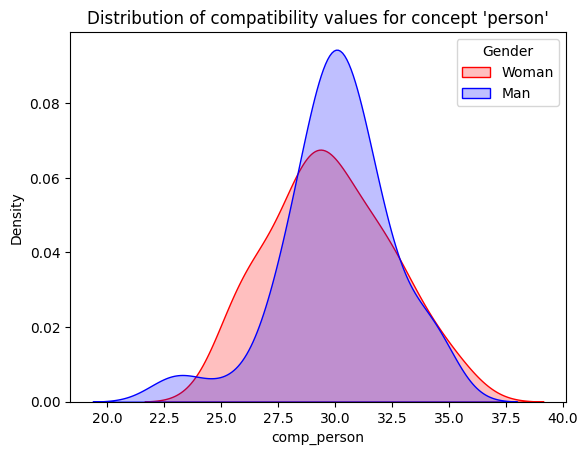

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Example data

# Create a new DataFrame to work seamlessly with Seaborn
import pandas as pd
data = pd.DataFrame({
    "comp_person": comp_person.reshape(-1),  # Flatten the array
    "man_woman": np.where(np.array(man_woman).reshape(-1) == 1, "Woman", "Man")  # Convert 0, 1 to labels
})

# Plot KDE using the `hue` parameter
sns.kdeplot(data=data, x="comp_person", hue="man_woman", fill=True, palette={"Woman": "red", "Man": "blue"})

# Add legend
plt.legend(['Woman', 'Man'], title="Gender")
plt.title("Distribution of compatibility values for concept 'person'")
plt.show()

In [38]:
import numpy as np
from scipy.special import rel_entr  # Relative entropy for KL divergence

# Example arrays (ensure they represent probability distributions)

min_len = min(sum(man_woman), len(man_woman) - sum(man_woman))
# Ensure both arrays sum to 1 (normalization step)
woman = comp_person[np.array(man_woman).reshape(-1) == 1][:min_len]
man = comp_person[np.array(man_woman).reshape(-1) == 0][:min_len]
p = woman / woman.sum()
q = man / man.sum()

print(min_len)

# Compute KL divergence
kl_divergence = np.sum(rel_entr(p, q))

print(f"KL Divergence: {kl_divergence}")

49
KL Divergence: 0.0059509724378585815


In [39]:
from scipy.stats import ks_2samp

# Example distributions

# Perform KS test
ks_stat, p_value = ks_2samp(woman.reshape(-1), man.reshape(-1))

print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.1836734693877551, p-value: 0.3833868439543752
The distributions are not significantly different.


# Beard vs. man

In [40]:
comp_bread = get_compatibility("Beard")

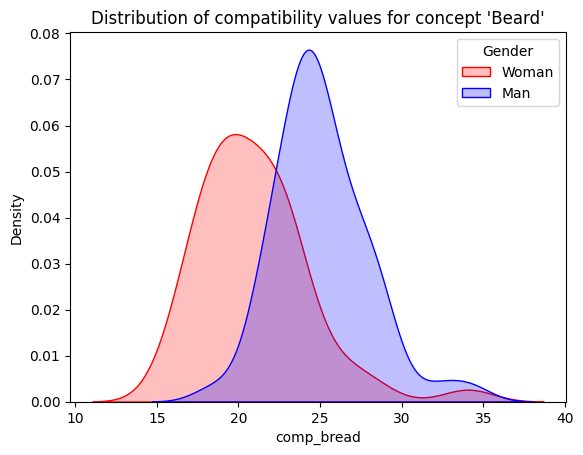

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Example data

# Create a new DataFrame to work seamlessly with Seaborn
import pandas as pd
data = pd.DataFrame({
    "comp_bread": comp_bread.reshape(-1),  # Flatten the array
    "man_woman": np.where(np.array(man_woman).reshape(-1) == 1, "Woman", "Man")  # Convert 0, 1 to labels
})

# Plot KDE using the `hue` parameter
sns.kdeplot(data=data, x="comp_bread", hue="man_woman", fill=True, palette={"Woman": "red", "Man": "blue"})

# Add legend
plt.legend(['Woman', 'Man'], title="Gender")
plt.title("Distribution of compatibility values for concept 'Beard'")
plt.show()

In [47]:
import numpy as np
from scipy.special import rel_entr  # Relative entropy for KL divergence

# Example arrays (ensure they represent probability distributions)

min_len = min(sum(man_woman), len(man_woman) - sum(man_woman))
# Ensure both arrays sum to 1 (normalization step)
woman = comp_bread[np.array(man_woman).reshape(-1) == 1][:min_len]
man = comp_bread[np.array(man_woman).reshape(-1) == 0][:min_len]
p = woman / woman.sum()
q = man / man.sum()

print(min_len)
# Compute KL divergence
kl_divergence = np.sum(rel_entr(p, q))

print(f"KL Divergence: {kl_divergence}")
print('mean', np.mean(man), np.mean(woman))

49
KL Divergence: 0.01051323488354683
mean 24.998358 20.942657


In [43]:
from scipy.stats import ks_2samp

# Example distributions

# Perform KS test
ks_stat, p_value = ks_2samp(woman.reshape(-1), man.reshape(-1))

print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.6530612244897959, p-value: 3.5888761835080957e-10
The distributions are significantly different.


# Person vs race

In [21]:
comp_white_latino = get_compatibility("person")

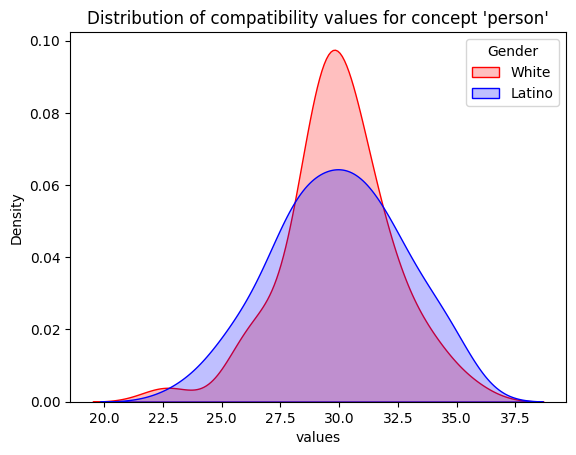

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Example data

# Create a new DataFrame to work seamlessly with Seaborn
import pandas as pd
data = pd.DataFrame({
    "values": comp_white_latino.reshape(-1),  # Flatten the array
    "white_latino": np.where(np.array(race).reshape(-1) == 1, "White", "Latino")  # Convert 0, 1 to labels
})

# Plot KDE using the `hue` parameter
sns.kdeplot(data=data, x="values", hue="white_latino", fill=True, palette={"White": "red", "Latino": "blue"})

# Add legend
plt.legend(['White', 'Latino'], title="Gender")
plt.title("Distribution of compatibility values for concept 'person'")
plt.show()

In [46]:
import numpy as np
from scipy.special import rel_entr  # Relative entropy for KL divergence

# Example arrays (ensure they represent probability distributions)

min_len = min(sum(race), len(race) - sum(race))
# Ensure both arrays sum to 1 (normalization step)
white = comp_white_latino[np.array(race).reshape(-1) == 1][:min_len].reshape(-1)
latino = comp_white_latino[np.array(race).reshape(-1) == 0][:min_len].reshape(-1)
p = white / white.sum()
q = latino / latino.sum()

print(min_len)
# Compute KL divergence
kl_divergence = np.sum(rel_entr(p, q))

print(f"KL Divergence: {kl_divergence}")
print('mean', np.mean(white), np.mean(latino))

50
KL Divergence: 0.007178348954766989
mean 29.92207 29.949074


In [33]:
from scipy.stats import ks_2samp

# Example distributions

# Perform KS test
ks_stat, p_value = ks_2samp(white.reshape(-1), latino.reshape(-1))

print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.16, p-value: 0.5486851446031328
The distributions are not significantly different.
